In [44]:
import numpy as np
import matplotlib.pyplot as plt
from environment import CustomGridWorld

In [45]:
# Define the policy network
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class PolicyNetwork:
    def __init__(self, state_size, action_size):
        self.theta = np.random.rand(state_size, action_size)

    def get_policy(self, state):
        preferences = self.theta[state]
        return softmax(preferences.reshape(1, -1))[0]

    def get_action(self, state):
        policy = self.get_policy(state)
        return np.random.choice(len(policy), p=policy)

In [46]:
# Define the value network
class ValueNetwork:
    def __init__(self, state_size):
        self.w = np.random.rand(state_size)

    def predict(self, state):
        return self.w[state]

    def update(self, state, td_error, alpha):
        self.w[state] += alpha * td_error

In [47]:
# Helper functions
def generate_episode(env, policy_network):
    states = []
    actions = []
    rewards = []
    state = env.reset()
    while not env.is_goal_state():
        action = policy_network.get_action(state)
        next_state, reward = env.step(policy_network.get_policy(state))
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
        if len(states) > 100:  # To prevent infinite loops
            break
    return states, actions, rewards

def discount_rewards(rewards, gamma):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0
    for i in reversed(range(len(rewards))):
        cumulative = cumulative * gamma + rewards[i]
        discounted[i] = cumulative
    return discounted

In [48]:
# REINFORCE algorithm
def reinforce(env, policy_network, episodes, gamma=0.99, alpha=0.01):
    all_rewards = []
    for episode in range(episodes):
        states, actions, rewards = generate_episode(env, policy_network)
        discounted_rewards = discount_rewards(rewards, gamma)
        all_rewards.append(sum(rewards))
        
        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            Gt = discounted_rewards[t]
            policy = policy_network.get_policy(state)
            dlog = np.zeros_like(policy)
            dlog[action] = 1 - policy[action]
            policy_network.theta[state] += alpha * gamma ** t * Gt * dlog
    
    return all_rewards

# Baseline REINFORCE algorithm
def baseline_reinforce(env, policy_network, value_network, episodes, gamma=0.99, alpha=0.01, beta=0.01):
    all_rewards = []
    for episode in range(episodes):
        states, actions, rewards = generate_episode(env, policy_network)
        discounted_rewards = discount_rewards(rewards, gamma)
        all_rewards.append(sum(rewards))
        
        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            Gt = discounted_rewards[t]
            baseline = value_network.predict(state)
            td_error = Gt - baseline
            
            policy = policy_network.get_policy(state)
            dlog = np.zeros_like(policy)
            dlog[action] = 1 - policy[action]
            policy_network.theta[state] += beta * gamma ** t * td_error * dlog
            value_network.update(state, td_error, alpha)
    
    return all_rewards

In [49]:
# Initialize environment and networks
env = CustomGridWorld()
state_size = env.grid_shape[0] * env.grid_shape[1]
action_size = 4

policy_network = PolicyNetwork(state_size, action_size)
value_network = ValueNetwork(state_size)

# Run algorithms
episodes = 10000
reinforce_rewards = reinforce(env, policy_network, episodes)

policy_network = PolicyNetwork(state_size, action_size)  # reinitialize policy network and run the algorithm
baseline_reinforce_rewards = baseline_reinforce(env, policy_network, value_network, episodes)

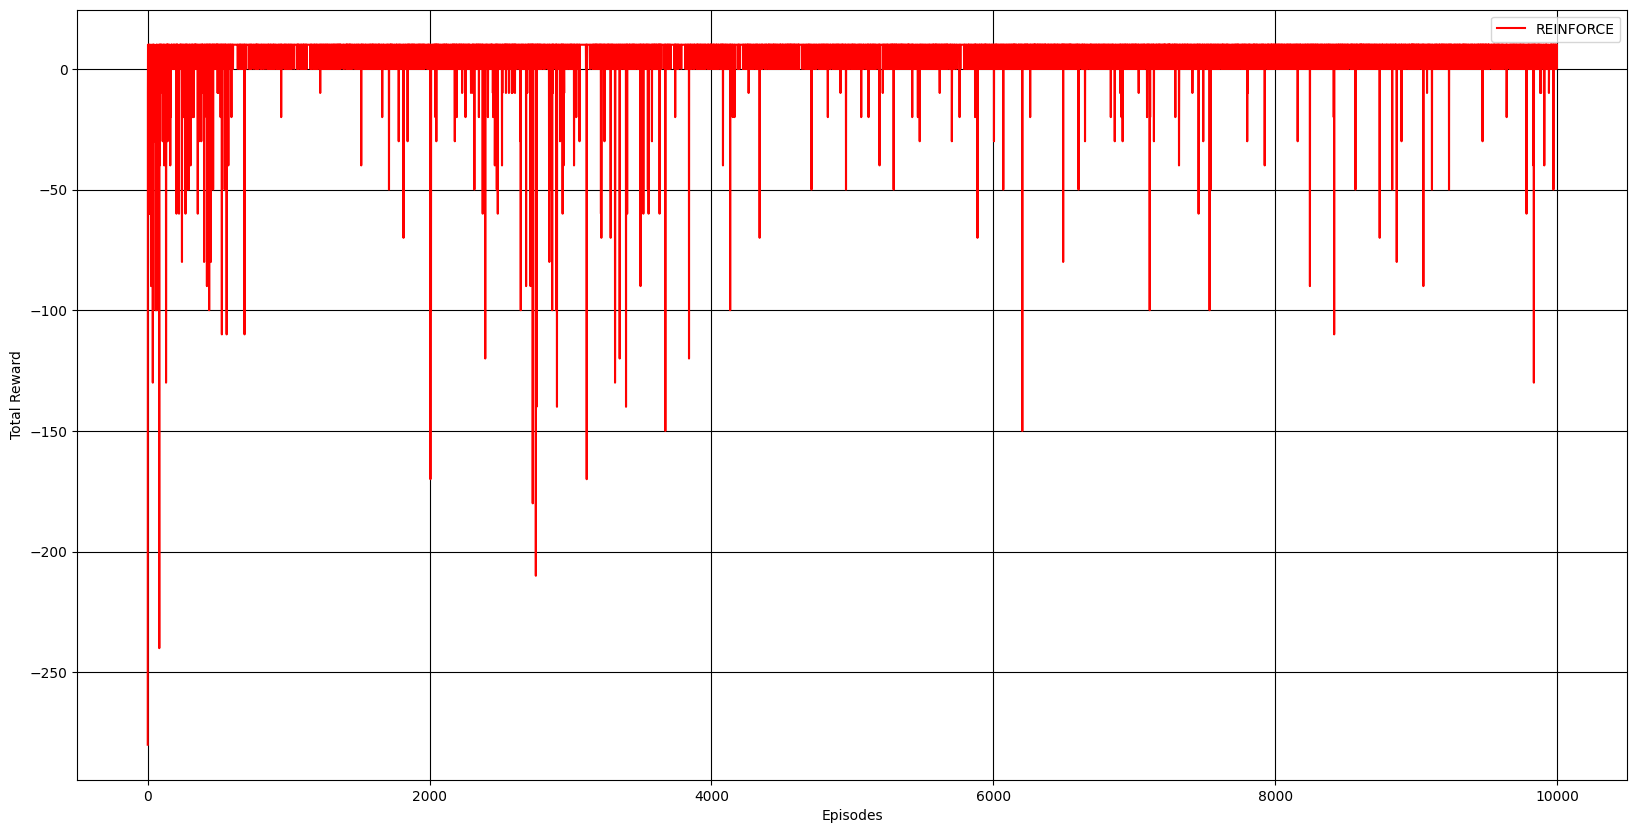

In [50]:
# Plot learning curves for reinforce
plt.figure(figsize=(20, 10))
plt.plot(reinforce_rewards, color = 'red', label='REINFORCE')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(color = 'black')
plt.show()

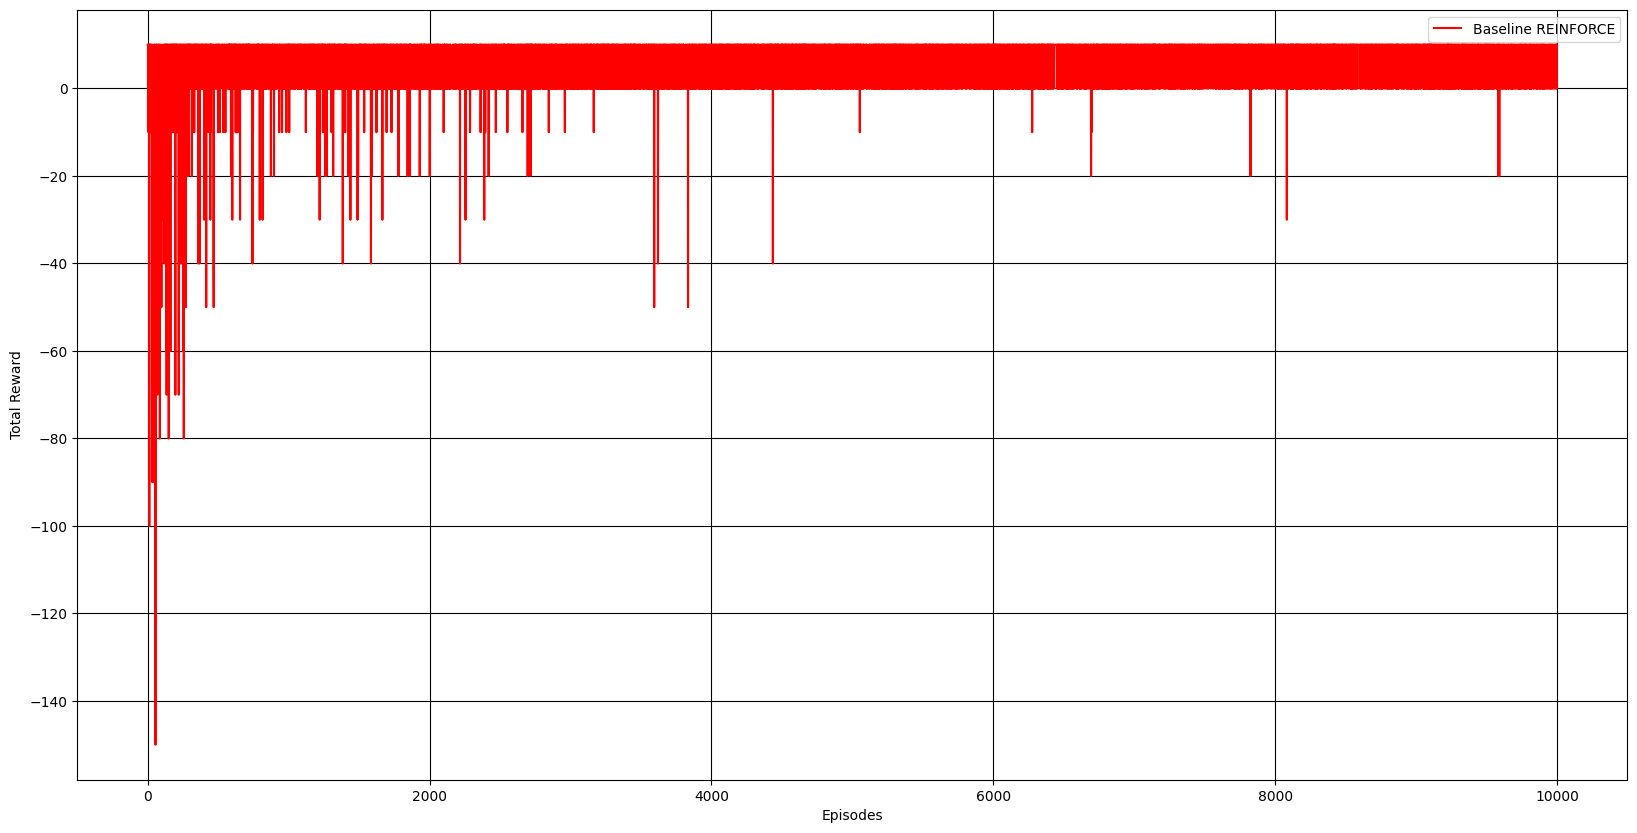

In [51]:
# Plot learning curves for baseline reinforce
plt.figure(figsize=(20, 10))
plt.plot(baseline_reinforce_rewards, color = 'red', label='Baseline REINFORCE')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(color = 'black')
plt.show()